In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.tree import DecisionTreeRegressor #a single decision tree
from sklearn.ensemble import RandomForestRegressor #random forest
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_absolute_error

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

import matplotlib.pyplot as plt

df = pd.read_csv('../input/melbourne-housing-snapshot/melb_data.csv')

df.head()


,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,...,1.0,1.0,202.0,NaN,NaN,Yarra,-37.7996,144.9984,Northern Metropolitan,4019.0
1,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,...,1.0,0.0,156.0,79.0,1900.0,Yarra,-37.8079,144.9934,Northern Metropolitan,4019.0
2,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,...,2.0,0.0,134.0,150.0,1900.0,Yarra,-37.8093,144.9944,Northern Metropolitan,4019.0
3,Abbotsford,40 Federation La,3,h,850000.0,PI,Biggin,4/03/2017,2.5,3067.0,...,2.0,1.0,94.0,NaN,NaN,Yarra,-37.7969,144.9969,Northern Metropolitan,4019.0
4,Abbotsford,55a Park St,4,h,1600000.0,VB,Nelson,4/06/2016,2.5,3067.0,...,1.0,2.0,120.0,142.0,2014.0,Yarra,-37.8072,144.9941,Northern Metropolitan,4019.0


In [2]:
df.Price

0        1480000.0
1        1035000.0
2        1465000.0
3         850000.0
4        1600000.0
           ...    
13575    1245000.0
13576    1031000.0
13577    1170000.0
13578    2500000.0
13579    1285000.0
Name: Price, Length: 13580, dtype: float64

In [3]:
df_2 = df.copy()

In [4]:
# Imputation
my_imputer = SimpleImputer()

numerical_transformer = pd.DataFrame(my_imputer.fit_transform(df_2.select_dtypes(include=['int64','float64'])))
numerical_transformer.columns = df_2.select_dtypes(include=['int64','float64']).columns

df_3 = numerical_transformer.join(df_2.select_dtypes(include=['object']))
df_3

,Rooms,Price,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,...,Longtitude,Propertycount,Suburb,Address,Type,Method,SellerG,Date,CouncilArea,Regionname
0,2.0,1480000.0,2.5,3067.0,2.0,1.0,1.0,202.0,151.96765,1964.684217,...,144.99840,4019.0,Abbotsford,85 Turner St,h,S,Biggin,3/12/2016,Yarra,Northern Metropolitan
1,2.0,1035000.0,2.5,3067.0,2.0,1.0,0.0,156.0,79.00000,1900.000000,...,144.99340,4019.0,Abbotsford,25 Bloomburg St,h,S,Biggin,4/02/2016,Yarra,Northern Metropolitan
2,3.0,1465000.0,2.5,3067.0,3.0,2.0,0.0,134.0,150.00000,1900.000000,...,144.99440,4019.0,Abbotsford,5 Charles St,h,SP,Biggin,4/03/2017,Yarra,Northern Metropolitan
3,3.0,850000.0,2.5,3067.0,3.0,2.0,1.0,94.0,151.96765,1964.684217,...,144.99690,4019.0,Abbotsford,40 Federation La,h,PI,Biggin,4/03/2017,Yarra,Northern Metropolitan
4,4.0,1600000.0,2.5,3067.0,3.0,1.0,2.0,120.0,142.00000,2014.000000,...,144.99410,4019.0,Abbotsford,55a Park St,h,VB,Nelson,4/06/2016,Yarra,Northern Metropolitan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13575,4.0,1245000.0,16.7,3150.0,4.0,2.0,2.0,652.0,151.96765,1981.000000,...,145.16761,7392.0,Wheelers Hill,12 Strada Cr,h,S,Barry,26/08/2017,NaN,South-Eastern Metropolitan
13576,3.0,1031000.0,6.8,3016.0,3.0,2.0,2.0,333.0,133.00000,1995.000000,...,144.87904,6380.0,Williamstown,77 Merrett Dr,h,SP,Williams,26/08/2017,NaN,Western Metropolitan
13577,3.0,1170000.0,6.8,3016.0,3.0,2.0,4.0,436.0,151.96765,1997.000000,...,144.88738,6380.0,Williamstown,83 Power St,h,S,Raine,26/08/2017,NaN,Western Metropolitan
13578,4.0,2500000.0,6.8,3016.0,4.0,1.0,5.0,866.0,157.00000,1920.000000,...,144.89299,6380.0,Williamstown,96 Verdon St,h,PI,Sweeney,26/08/2017,NaN,Western Metropolitan


In [5]:
X = df_3.copy()
y = X.pop("Price")
for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()
discrete_features = X.dtypes == int
def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores

Address          1.439318
Suburb           0.402707
Postcode         0.322511
Rooms            0.221696
Bedroom2         0.212726
Distance         0.209115
Propertycount    0.205193
CouncilArea      0.197458
BuildingArea     0.195540
Type             0.176480
SellerG          0.167275
Longtitude       0.154934
Lattitude        0.148747
Landsize         0.145599
Method           0.120679
Bathroom         0.119534
Regionname       0.103054
YearBuilt        0.099514
Car              0.094226
Date             0.017545
Name: MI Scores, dtype: float64

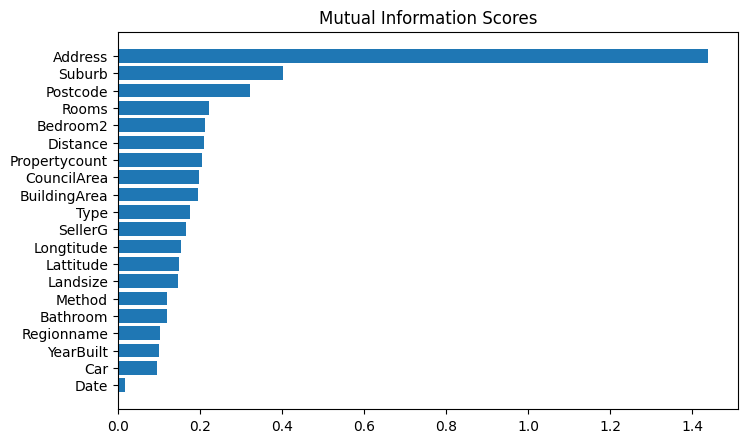

In [6]:

def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

In [7]:
df_3.isnull().sum()

Rooms               0
Price               0
Distance            0
Postcode            0
Bedroom2            0
Bathroom            0
Car                 0
Landsize            0
BuildingArea        0
YearBuilt           0
Lattitude           0
Longtitude          0
Propertycount       0
Suburb              0
Address             0
Type                0
Method              0
SellerG             0
Date                0
CouncilArea      1369
Regionname          0
dtype: int64

In [8]:
output = df_3.Price
# features = ['Address','BuildingArea','Suburb','Postcode','Rooms','Bedroom2','CouncilArea','Type','Propertycount','SellerG','Distance','Landsize','YearBuilt','Bathroom','Lattitude','Longtitude','Regionname','Method','Car','Date']
features = ['Address','BuildingArea','Suburb','Postcode','Rooms','Bedroom2','Type','Propertycount','SellerG','Distance','Landsize','YearBuilt','Bathroom','Lattitude','Longtitude','Regionname']
inputs = df_3[features]

inputs

,Address,BuildingArea,Suburb,Postcode,Rooms,Bedroom2,Type,Propertycount,SellerG,Distance,Landsize,YearBuilt,Bathroom,Lattitude,Longtitude,Regionname
0,85 Turner St,151.96765,Abbotsford,3067.0,2.0,2.0,h,4019.0,Biggin,2.5,202.0,1964.684217,1.0,-37.79960,144.99840,Northern Metropolitan
1,25 Bloomburg St,79.00000,Abbotsford,3067.0,2.0,2.0,h,4019.0,Biggin,2.5,156.0,1900.000000,1.0,-37.80790,144.99340,Northern Metropolitan
2,5 Charles St,150.00000,Abbotsford,3067.0,3.0,3.0,h,4019.0,Biggin,2.5,134.0,1900.000000,2.0,-37.80930,144.99440,Northern Metropolitan
3,40 Federation La,151.96765,Abbotsford,3067.0,3.0,3.0,h,4019.0,Biggin,2.5,94.0,1964.684217,2.0,-37.79690,144.99690,Northern Metropolitan
4,55a Park St,142.00000,Abbotsford,3067.0,4.0,3.0,h,4019.0,Nelson,2.5,120.0,2014.000000,1.0,-37.80720,144.99410,Northern Metropolitan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13575,12 Strada Cr,151.96765,Wheelers Hill,3150.0,4.0,4.0,h,7392.0,Barry,16.7,652.0,1981.000000,2.0,-37.90562,145.16761,South-Eastern Metropolitan
13576,77 Merrett Dr,133.00000,Williamstown,3016.0,3.0,3.0,h,6380.0,Williams,6.8,333.0,1995.000000,2.0,-37.85927,144.87904,Western Metropolitan
13577,83 Power St,151.96765,Williamstown,3016.0,3.0,3.0,h,6380.0,Raine,6.8,436.0,1997.000000,2.0,-37.85274,144.88738,Western Metropolitan
13578,96 Verdon St,157.00000,Williamstown,3016.0,4.0,4.0,h,6380.0,Sweeney,6.8,866.0,1920.000000,1.0,-37.85908,144.89299,Western Metropolitan


In [9]:
inputs['Suburb'].nunique()

314

In [10]:
categorical_cols = [cname for cname in inputs.columns if inputs[cname].nunique() <= 314 and inputs[cname].dtype == "object"]
categorical_cols

['Suburb', 'Type', 'SellerG', 'Regionname']

In [11]:
ordinal_encoder = OrdinalEncoder()
input_enc = inputs.copy()
inputs[categorical_cols] = ordinal_encoder.fit_transform(input_enc[categorical_cols])
inputs

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


,Address,BuildingArea,Suburb,Postcode,Rooms,Bedroom2,Type,Propertycount,SellerG,Distance,Landsize,YearBuilt,Bathroom,Lattitude,Longtitude,Regionname
0,85 Turner St,151.96765,0.0,3067.0,2.0,2.0,0.0,4019.0,23.0,2.5,202.0,1964.684217,1.0,-37.79960,144.99840,2.0
1,25 Bloomburg St,79.00000,0.0,3067.0,2.0,2.0,0.0,4019.0,23.0,2.5,156.0,1900.000000,1.0,-37.80790,144.99340,2.0
2,5 Charles St,150.00000,0.0,3067.0,3.0,3.0,0.0,4019.0,23.0,2.5,134.0,1900.000000,2.0,-37.80930,144.99440,2.0
3,40 Federation La,151.96765,0.0,3067.0,3.0,3.0,0.0,4019.0,23.0,2.5,94.0,1964.684217,2.0,-37.79690,144.99690,2.0
4,55a Park St,142.00000,0.0,3067.0,4.0,3.0,0.0,4019.0,155.0,2.5,120.0,2014.000000,1.0,-37.80720,144.99410,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13575,12 Strada Cr,151.96765,302.0,3150.0,4.0,4.0,0.0,7392.0,16.0,16.7,652.0,1981.000000,2.0,-37.90562,145.16761,4.0
13576,77 Merrett Dr,133.00000,305.0,3016.0,3.0,3.0,0.0,6380.0,251.0,6.8,333.0,1995.000000,2.0,-37.85927,144.87904,6.0
13577,83 Power St,151.96765,305.0,3016.0,3.0,3.0,0.0,6380.0,194.0,6.8,436.0,1997.000000,2.0,-37.85274,144.88738,6.0
13578,96 Verdon St,157.00000,305.0,3016.0,4.0,4.0,0.0,6380.0,222.0,6.8,866.0,1920.000000,1.0,-37.85908,144.89299,6.0


In [12]:
#Address
print('null values:',inputs['Address'].isnull().sum())
print(inputs['Address'].value_counts())
inputs=pd.get_dummies(inputs, columns=['Address'])

null values: 0
36 Aberfeldie St    3
2 Bruce St          3
5 Charles St        3
53 William St       3
14 Arthur St        3
                   ..
16 Alleford St      1
2/1073 Centre Rd    1
14 Columbia St      1
21 Hardy Ct         1
6 Agnes St          1
Name: Address, Length: 13378, dtype: int64


In [13]:
inputs

,BuildingArea,Suburb,Postcode,Rooms,Bedroom2,Type,Propertycount,SellerG,Distance,Landsize,...,Address_9A Montgomery St,Address_9A Normanby St,Address_9A The Crossway,Address_9a Arden Ct,Address_9a Ballater St,Address_9a Elizabeth St,Address_9a Ivan Av,Address_9a Russell St,Address_9a The Crossway,Address_9b Stewart St
0,151.96765,0.0,3067.0,2.0,2.0,0.0,4019.0,23.0,2.5,202.0,...,0,0,0,0,0,0,0,0,0,0
1,79.00000,0.0,3067.0,2.0,2.0,0.0,4019.0,23.0,2.5,156.0,...,0,0,0,0,0,0,0,0,0,0
2,150.00000,0.0,3067.0,3.0,3.0,0.0,4019.0,23.0,2.5,134.0,...,0,0,0,0,0,0,0,0,0,0
3,151.96765,0.0,3067.0,3.0,3.0,0.0,4019.0,23.0,2.5,94.0,...,0,0,0,0,0,0,0,0,0,0
4,142.00000,0.0,3067.0,4.0,3.0,0.0,4019.0,155.0,2.5,120.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13575,151.96765,302.0,3150.0,4.0,4.0,0.0,7392.0,16.0,16.7,652.0,...,0,0,0,0,0,0,0,0,0,0
13576,133.00000,305.0,3016.0,3.0,3.0,0.0,6380.0,251.0,6.8,333.0,...,0,0,0,0,0,0,0,0,0,0
13577,151.96765,305.0,3016.0,3.0,3.0,0.0,6380.0,194.0,6.8,436.0,...,0,0,0,0,0,0,0,0,0,0
13578,157.00000,305.0,3016.0,4.0,4.0,0.0,6380.0,222.0,6.8,866.0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
# s = (inputs.dtypes == 'object')
# object_cols = list(s[s].index)
# OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
# OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(inputs[object_cols]))
# OH_cols_train.index = inputs.index
# num_X_train = inputs.drop(object_cols, axis=1)
# X_train = pd.concat([num_X_train, OH_cols_train], axis=1)
# X_train.head()

In [15]:
train_X, val_X, train_y, val_y = train_test_split(inputs, output, random_state = 0)

In [16]:
train_X.count()

BuildingArea               10185
Suburb                     10185
Postcode                   10185
Rooms                      10185
Bedroom2                   10185
                           ...  
Address_9a Elizabeth St    10185
Address_9a Ivan Av         10185
Address_9a Russell St      10185
Address_9a The Crossway    10185
Address_9b Stewart St      10185
Length: 13393, dtype: int64

In [17]:
# random forest 
def score_dataset(train_X, val_X, train_y, val_y):
    model = RandomForestRegressor(n_estimators=10, random_state=1)
    model.fit(train_X, train_y)
    predicted_home_prices = model.predict(val_X)
    MAE = mean_absolute_error(val_y, predicted_home_prices)
    return MAE

In [18]:
print("MAE : ")
print(score_dataset(train_X, val_X, train_y, val_y))


MAE : 
171310.93115365732
